## Pytorch Lightning version of Resnet18 baseline 

In [1]:
# common imports
import os
import math
import time
import random
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
from typing import Dict
from tqdm import tqdm
from pathlib import Path
from tempfile import gettempdir

# interactive plot libraries
import matplotlib.pyplot as plt
from plotly.offline import init_notebook_mode, iplot # download_plotlyjs, plot
import plotly.graph_objs as go
from plotly.subplots import make_subplots
init_notebook_mode(connected=True)

# torch imports
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchvision.models.resnet import resnet50, resnet18, resnet34, resnet101
import torch.nn.functional as F

#from torch_lr_finder import LRFinder

# l5kit imports
import l5kit
from l5kit.configs import load_config_data
from l5kit.data import LocalDataManager, ChunkedDataset
from l5kit.dataset import AgentDataset, EgoDataset
from l5kit.rasterization import build_rasterizer
from l5kit.evaluation import write_pred_csv, compute_metrics_csv, read_gt_csv, create_chopped_dataset
from l5kit.evaluation.chop_dataset import MIN_FUTURE_STEPS
from l5kit.evaluation.metrics import neg_multi_log_likelihood, time_displace
from l5kit.geometry import transform_points
from l5kit.visualization import PREDICTED_POINTS_COLOR, TARGET_POINTS_COLOR, draw_trajectory

In [2]:
import pytorch_lightning as pl

In [3]:
print(torch.__version__)

1.6.0


In [4]:
print(l5kit.__version__)

1.1.0


In [5]:
def find_no_of_trainable_params(model):
    total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    #print(total_trainable_params)
    return total_trainable_params

In [6]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    
set_seed(42)

## Configs

In [7]:
# --- Lyft configs ---
cfg = {
    'format_version': 4,
    'data_path': "../../lyft-motion-prediction-autonomous-vehicles/",
    'model_params': {
        'model_architecture': 'resnet18',
        'history_num_frames': 10,
        'history_step_size': 1,
        'history_delta_time': 0.1,
        'future_num_frames': 50,
        'future_step_size': 1,
        'future_delta_time': 0.1,
        'model_name': "R18_10_330_180_dr_conclusion",
        'lr': 6.3e-6,
        'weight_path': "R18_10_330_180_dr_conclusion_2784k.pth",
        'lr_find' : True, 
        'train': True, 
        'validate': False,
        'test': False
    },

    'raster_params': {
        'raster_size': [330, 180],
        'pixel_size': [0.4, 0.4],
        'ego_center': [0.25, 0.5],
        'map_type': 'py_semantic',
        'satellite_map_key': 'aerial_map/aerial_map.png',
        'semantic_map_key': 'semantic_map/semantic_map.pb',
        'dataset_meta_key': 'meta.json',
        'filter_agents_threshold': 0.5
    },

    'train_data_loader': {
        'key': 'scenes/train.zarr',
        'batch_size': 16,
        'shuffle': True,
        'num_workers': 4
    },
    
    'val_data_loader': {
        'key': 'scenes/validate.zarr',
        'batch_size': 16,
        'shuffle': True,
        'num_workers': 4
    },

    
    'test_data_loader': {
        'key': 'scenes/test.zarr',
        'batch_size': 32,
        'shuffle': False,
        'num_workers': 4
    },

    'train_params': {
        'train_start_index' : 174001,
        'max_num_steps': 11,
        'checkpoint_every_n_steps': 5,
        'reduction_factor' : 0.9,
        'step_size' : 1e5
    }
}

In [8]:
NUMBER_OF_HISTORY_FRAMES = cfg['model_params']['history_num_frames'] + 1
RASTER_IMG_SIZE = cfg['raster_params']['raster_size'][0]
NUM_MODES = 3
NUMBER_OF_FUTURE_FRAMES = cfg['model_params']['future_num_frames']

### TRAIN FROM WHERE LEFT OFF, CHANGE THE STARTING INDICES VARIABLE ACCORDINGLY
TRAIN_BATCH_SIZE = cfg['train_data_loader']['batch_size'] 
TRAIN_START_INDICES = cfg['train_params']['train_start_index']
EXTENT_RANGE = 5.0 
MIN_FRAMES_FUTURE = 10

In [9]:
EXTENT_RANGE = 5.0 
MAX_VELOCITY = 20.0
MAX_ACCELERATION = 2.0
MAX_YAW_RATE = np.deg2rad(45)
dt =cfg['model_params']['history_delta_time']

## Rasterize and initialise

In [10]:
# set env variable for data
DIR_INPUT = cfg["data_path"]
os.environ["L5KIT_DATA_FOLDER"] = DIR_INPUT
dm = LocalDataManager(None)
rasterizer = build_rasterizer(cfg, dm)

## Loss function

In [11]:
# --- Function utils ---
# Original code from https://github.com/lyft/l5kit/blob/20ab033c01610d711c3d36e1963ecec86e8b85b6/l5kit/l5kit/evaluation/metrics.py
from torch import Tensor


def pytorch_neg_multi_log_likelihood_batch(
    gt: Tensor, pred: Tensor, confidences: Tensor, avails: Tensor
) -> Tensor:
    """
    Compute a negative log-likelihood for the multi-modal scenario.
    log-sum-exp trick is used here to avoid underflow and overflow, For more information about it see:
    https://en.wikipedia.org/wiki/LogSumExp#log-sum-exp_trick_for_log-domain_calculations
    https://timvieira.github.io/blog/post/2014/02/11/exp-normalize-trick/
    https://leimao.github.io/blog/LogSumExp/
    Args:
        gt (Tensor): array of shape (bs)x(time)x(2D coords)
        pred (Tensor): array of shape (bs)x(modes)x(time)x(2D coords)
        confidences (Tensor): array of shape (bs)x(modes) with a confidence for each mode in each sample
        avails (Tensor): array of shape (bs)x(time) with the availability for each gt timestep
    Returns:
        Tensor: negative log-likelihood for this example, a single float number
    """
    assert len(pred.shape) == 4, f"expected 3D (MxTxC) array for pred, got {pred.shape}"
    batch_size, num_modes, future_len, num_coords = pred.shape

    assert gt.shape == (batch_size, future_len, num_coords), f"expected 2D (Time x Coords) array for gt, got {gt.shape}"
    assert confidences.shape == (batch_size, num_modes), f"expected 1D (Modes) array for gt, got {confidences.shape}"
    assert torch.allclose(torch.sum(confidences, dim=1), confidences.new_ones((batch_size,))), "confidences should sum to 1"
    assert avails.shape == (batch_size, future_len), f"expected 1D (Time) array for gt, got {avails.shape}"
    # assert all data are valid
    assert torch.isfinite(pred).all(), "invalid value found in pred"
    assert torch.isfinite(gt).all(), "invalid value found in gt"
    assert torch.isfinite(confidences).all(), "invalid value found in confidences"
    assert torch.isfinite(avails).all(), "invalid value found in avails"

    # convert to (batch_size, num_modes, future_len, num_coords)
    gt = torch.unsqueeze(gt, 1)  # add modes
    avails = avails[:, None, :, None]  # add modes and cords

    # error (batch_size, num_modes, future_len)
    error = torch.sum(((gt - pred) * avails) ** 2, dim=-1)  # reduce coords and use availability

    with np.errstate(divide="ignore"):  # when confidence is 0 log goes to -inf, but we're fine with it
        # error (batch_size, num_modes)
        error = torch.log(confidences) - 0.5 * torch.sum(error, dim=-1)  # reduce time

    # use max aggregator on modes for numerical stability
    # error (batch_size, num_modes)
    max_value, _ = error.max(dim=1, keepdim=True)  # error are negative at this point, so max() gives the minimum one
    error = -torch.log(torch.sum(torch.exp(error - max_value), dim=-1, keepdim=True)) - max_value  # reduce modes
    # print("error", error)
    return torch.mean(error)


def pytorch_neg_multi_log_likelihood_single(
    gt: Tensor, pred: Tensor, avails: Tensor
) -> Tensor:
    """

    Args:
        gt (Tensor): array of shape (bs)x(time)x(2D coords)
        pred (Tensor): array of shape (bs)x(time)x(2D coords)
        avails (Tensor): array of shape (bs)x(time) with the availability for each gt timestep
    Returns:
        Tensor: negative log-likelihood for this example, a single float number
    """
    # pred (bs)x(time)x(2D coords) --> (bs)x(mode=1)x(time)x(2D coords)
    # create confidence (bs)x(mode=1)
    batch_size, future_len, num_coords = pred.shape
    confidences = pred.new_ones((batch_size, 1))
    return pytorch_neg_multi_log_likelihood_batch(gt, pred.unsqueeze(1), confidences, avails)

## Model

In [12]:
class Lit_MotionPredictor(pl.LightningModule):
    def __init__(self, cfg: Dict, criterion, num_modes=3, lr=cfg['model_params']['lr']):
        super().__init__()
        
        architecture = cfg["model_params"]["model_architecture"]
        # This is 512 for resnet18 and resnet34; And it is 2048 for the other resnets
        if architecture == "resnet50":
            backbone_out_features = 2048
        else:
            backbone_out_features = 512

        num_history_channels = (cfg["model_params"]["history_num_frames"] + 1) * 2
        num_in_channels = 3 + num_history_channels

        # X, Y coords for the future positions (output shape: batch_sizex50x2)
        self.future_len = cfg["model_params"]["future_num_frames"]
        num_targets = 2 * cfg["model_params"]["future_num_frames"]
        self.num_preds = num_targets * num_modes
        self.num_modes = num_modes

        ##### Layers of the model #####
        backbone = eval(architecture)(pretrained=True)
        self.backbone = backbone
        self.backbone.conv1 = nn.Conv2d(
            num_in_channels,
            self.backbone.conv1.out_channels,
            kernel_size=self.backbone.conv1.kernel_size,
            stride=self.backbone.conv1.stride,
            padding=self.backbone.conv1.padding,
            bias=False,
        )
        
        # dropout layer
        self.dropout = nn.Dropout(p =0.4)
        
        # You can add more layers here.
        self.fc1 = nn.Linear(in_features=backbone_out_features, out_features=2048)
        self.fc2 = nn.Linear(in_features=2048, out_features=512)
        self.fc_out = nn.Linear(512, out_features= self.num_preds + self.num_modes)
        
        # loss function
        self.criterion = criterion
        
        # learning_rate assign
        self.learning_rate = lr

    def forward(self, x):
        x = self.backbone.conv1(x)
        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)

        x = self.backbone.layer1(x)
        x = self.backbone.layer2(x)
        x = self.backbone.layer3(x)
        x = self.backbone.layer4(x)

        x = self.backbone.avgpool(x)
        x = torch.flatten(x, 1)
        
        # fc layers
        x = self.dropout(self.fc1(x))
        x = self.dropout(self.fc2(x))
        x = self.fc_out(x)

        # pred (batch_size)x(modes)x(time)x(2D coords)
        # confidences (batch_size)x(modes)
        bs, _ = x.shape
        pred, confidences = torch.split(x, self.num_preds, dim=1)
        pred = pred.view(bs, self.num_modes, self.future_len, 2)
        assert confidences.shape == (bs, self.num_modes)
        confidences = torch.softmax(confidences, dim=1)
        return pred, confidences
    
    def training_step(self, batch, batch_idx):
        #print(batch_idx)
        inputs = batch["image"]
        target_availabilities = batch["target_availabilities"]
        targets = batch["target_positions"]
        
        # Forward pass
        preds, confidences = self.forward(inputs)
        loss = self.criterion(targets, preds, confidences, target_availabilities)
        return loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

In [13]:
model = Lit_MotionPredictor(cfg, pytorch_neg_multi_log_likelihood_batch, 3)

## Train Dataloader

In [14]:
# ===== INIT TRAIN DATASET============================================================
if (cfg['model_params']['train'] == True) or (cfg['model_params']['lr_find'] == True):
    train_cfg = cfg["train_data_loader"]
    train_zarr = ChunkedDataset(dm.require(train_cfg["key"])).open()
    train_dataset = AgentDataset(cfg, train_zarr, rasterizer, min_frame_future=MIN_FRAMES_FUTURE)
    
    print('Length of Train dataset is ' ,len(train_dataset))
    print("==================================TRAIN DATA==================================")
    print(train_dataset)
    
    sampled_indices = np.random.choice(len(train_dataset), size = len(train_dataset), replace = False)
    print('Before slicing, start indices are ', sampled_indices[0:10])
    print('TRAIN_START_INDICES', TRAIN_START_INDICES)
    
    sampled_indices = sampled_indices[TRAIN_START_INDICES:]
    print('After slicing, start indices are ', sampled_indices[0:10])
    
    Datasampler = SubsetRandomSampler(sampled_indices)
    train_dataloader = DataLoader(train_dataset, sampler=Datasampler, batch_size=train_cfg["batch_size"], 
                             num_workers=train_cfg["num_workers"])

Length of Train dataset is  17003687
==================================TRAIN DATA==================================
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
| Num Scenes | Num Frames | Num Agents | Num TR lights | Total Time (hr) | Avg Frames per Scene | Avg Agents per Frame | Avg Scene Time (sec) | Avg Frame frequency |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
|   16265    |  4039527   | 320124624  |    38735988   |      112.19     |        248.36        |        79.25         |        24.83         |        10.00        |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
Before slicing, start indices are  [11022119 16329088 

In [37]:
len(train_dataloader)

1051856

In [38]:
len(train_dataset)

17003687

In [41]:
(len(train_dataset) - len(train_dataloader) * 16) 

173991

## Validation Dataloader

In [15]:
eval_base_path = cfg['data_path'] + 'scenes/validate_chopped_100'
eval_cfg = cfg["val_data_loader"]
eval_zarr_path = str(Path(eval_base_path) / Path(dm.require(eval_cfg["key"])).name)
eval_mask_path = str(Path(eval_base_path) / "mask.npz")
eval_gt_path = str(Path(eval_base_path) / "gt.csv")

eval_zarr = ChunkedDataset(eval_zarr_path).open()
eval_mask = np.load(eval_mask_path)["arr_0"]
# ===== INIT DATASET AND LOAD MASK
eval_dataset = AgentDataset(cfg, eval_zarr, rasterizer, agents_mask=eval_mask)
eval_dataloader = DataLoader(eval_dataset, shuffle=eval_cfg["shuffle"], batch_size=eval_cfg["batch_size"], 
                             num_workers=eval_cfg["num_workers"])
print(eval_dataset)

+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
| Num Scenes | Num Frames | Num Agents | Num TR lights | Total Time (hr) | Avg Frames per Scene | Avg Agents per Frame | Avg Scene Time (sec) | Avg Frame frequency |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
|   16220    |  1622000   | 125423254  |    11733321   |      45.06      |        100.00        |        77.33         |        10.00         |        10.00        |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+


In [26]:
trainer = pl.Trainer(gpus=1, max_steps=cfg['train_params']['max_num_steps'],
                    limit_val_batches=0)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [17]:
# Run learning rate finder
lr_finder = trainer.tuner.lr_find(model, max_lr=1e-2, train_dataloader=train_dataloader)


  | Name     | Type    | Params
-------------------------------------
0 | backbone | ResNet  | 11 M  
1 | dropout  | Dropout | 0     
2 | fc1      | Linear  | 1 M   
3 | fc2      | Linear  | 1 M   
4 | fc_out   | Linear  | 155 K 


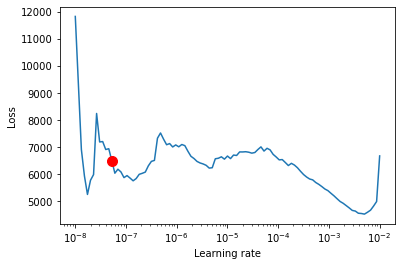

In [19]:
fig = lr_finder.plot(suggest=True)
fig.show()

In [21]:
print('Before lr : ', model.learning_rate)
model.learning_rate = lr_finder.suggestion()
print('AFTER lr : ', model.learning_rate)

5.248074602497726e-08

In [27]:
trainer.fit(model, train_dataloader=train_dataloader, val_dataloaders=eval_dataloader, limit)


  | Name     | Type    | Params
-------------------------------------
0 | backbone | ResNet  | 11 M  
1 | dropout  | Dropout | 0     
2 | fc1      | Linear  | 1 M   
3 | fc2      | Linear  | 1 M   
4 | fc_out   | Linear  | 155 K 


1

In [30]:
trainer.save_checkpoint('example.ckpt')

In [31]:
class LyftMultiModel(nn.Module):

    def __init__(self, cfg: Dict, num_modes=3):
        super().__init__()

        architecture = cfg["model_params"]["model_architecture"]
        backbone = eval(architecture)(pretrained=True)
        self.backbone = backbone

        num_history_channels = (cfg["model_params"]["history_num_frames"] + 1) * 2
        num_in_channels = 3 + num_history_channels

        self.backbone.conv1 = nn.Conv2d(
            num_in_channels,
            self.backbone.conv1.out_channels,
            kernel_size=self.backbone.conv1.kernel_size,
            stride=self.backbone.conv1.stride,
            padding=self.backbone.conv1.padding,
            bias=False,
        )

        # This is 512 for resnet18 and resnet34;
        # And it is 2048 for the other resnets
        
        if architecture == "resnet50":
            backbone_out_features = 2048
        else:
            backbone_out_features = 512

        # X, Y coords for the future positions (output shape: batch_sizex50x2)
        self.future_len = cfg["model_params"]["future_num_frames"]
        num_targets = 2 * self.future_len
        
        # dropout layer
        self.dropout = nn.Dropout(p =0.4)
        
        # You can add more layers here.
        self.fc1 = nn.Linear(in_features=backbone_out_features, out_features=2048)
        self.fc2 = nn.Linear(in_features=2048, out_features=512)

        self.num_preds = num_targets * num_modes
        self.num_modes = num_modes

        self.fc_out = nn.Linear(512, out_features=self.num_preds + num_modes)

    def forward(self, x):
        x = self.backbone.conv1(x)
        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)

        x = self.backbone.layer1(x)
        x = self.backbone.layer2(x)
        x = self.backbone.layer3(x)
        x = self.backbone.layer4(x)

        x = self.backbone.avgpool(x)
        x = torch.flatten(x, 1)
        
        # fc layers
        x = self.dropout(self.fc1(x))
        x = self.dropout(self.fc2(x))
        x = self.fc_out(x)

        # pred (batch_size)x(modes)x(time)x(2D coords)
        # confidences (batch_size)x(modes)
        bs, _ = x.shape
        pred, confidences = torch.split(x, self.num_preds, dim=1)
        pred = pred.view(bs, self.num_modes, self.future_len, 2)
        assert confidences.shape == (bs, self.num_modes)
        confidences = torch.softmax(confidences, dim=1)
        return pred, confidences

In [32]:
pytorch_model = LyftMultiModel(cfg)

In [33]:
checkpoint = torch.load('R18_10_330_180_dr_conclusion_880k.pth')

In [34]:
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [35]:
model

Lit_MotionPredictor(
  (backbone): ResNet(
    (conv1): Conv2d(25, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=T

In [36]:
checkpoint.keys()

dict_keys(['state_dict', 'optimizer'])

In [ ]:
trainer.

### LR_finder 

## Training loop

## Validation loop